# Klassifikation der Tweets durch einen Random Forest

In [1]:
# !python -m spacy download de_core_news_lg

In [2]:
%%capture --no-display
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
import spacy
import re
import umap
nlp = spacy.load('de_core_news_lg')

In [3]:
df = pd.read_csv("prepared_dataframe.csv")

In [4]:
df.head()

,tweet,binaereKlassifikation,granulareKlassifikation,Wörter in Tweet,Wörter pro Tweet,Tweets ohne Satzzeichen,Wortlänge,Durchschnittliche Wortlänge,Verlinkungen,Verlinkung pro Tweet,Hashtags,Hashtags pro Tweet,utf Codes,utf Codes pro Tweet,Emojis,Emojis pro Tweet,tweets_clean
0,@JanZimmHHB @mopo Komisch das die Realitätsver...,OFFENSE,INSULT,"['komisch', 'das', 'die', 'realitätsverweigeru...",11,"['Komisch', 'das', 'die', 'Realitätsverweigeru...","[7, 3, 3, 21, 5, 3, 6, 12, 9, 8, 7]",7.64,"['@JanZimmHHB', '@mopo']",2,[],0,[],0,[],0,komisch das die realitätsverweigerung immer vo...
1,@faznet @Gruene_Europa @SPDEuropa @CDU CDU ste...,OFFENSE,ABUSE,"['cdu', 'steht', 'seid', 'strauss,', 'kohl,', ...",13,"['CDU', 'steht', 'seid', 'Strauss', 'Kohl', 'S...","[3, 5, 4, 7, 4, 8, 7, 3, 10, 11, 3, 4, 7]",5.85,"['@faznet', '@Gruene_Europa', '@SPDEuropa', '@...",4,[],0,[],0,[],0,"cdu steht seid strauss, kohl, schäuble, vdleye..."
2,"@DLFNachrichten Die Gesichter, Namen, Religion...",OTHER,OTHER,"['die', 'gesichter,', 'namen,', 'religion', 'd...",10,"['Die', 'Gesichter', 'Namen', 'Religion', 'der...","[3, 9, 5, 8, 3, 5, 5, 3, 10, 9]",6.00,['@DLFNachrichten'],1,[],0,[],0,[],0,"die gesichter, namen, religion der täter würde..."
3,@welt Wie verwirrt muss man sein um sich zu we...,OFFENSE,ABUSE,"['wie', 'verwirrt', 'muss', 'man', 'sein', 'um...",28,"['Wie', 'verwirrt', 'muss', 'man', 'sein', 'um...","[3, 8, 4, 3, 4, 2, 4, 2, 7, 3, 9, 12, 3, 6, 4,...",5.43,['@welt'],1,[],0,[],0,[],0,wie verwirrt muss man sein um sich zu weigern ...
4,@hacker_1991 @torben_braga Weil die AfD den Fe...,OFFENSE,ABUSE,"['weil', 'die', 'afd', 'den', 'ferkelfunk', 'a...",30,"['Weil', 'die', 'AfD', 'den', 'Ferkelfunk', 'a...","[4, 3, 3, 3, 10, 10, 4, 7, 5, 3, 6, 6, 11, 5, ...",5.17,"['@hacker_1991', '@torben_braga']",2,[],0,[],0,[],0,"weil die afd den ferkelfunk abschaffen will, d..."


In [5]:
# Combine german stopwords from nltk with additional stopwords
german_stopwords1 = []
with open('./data/stop_words_german.txt', encoding="utf-8") as f:
    for line in f:
        line = line.replace('\n','')
        german_stopwords1.append(line)

german_stopwords2 = stopwords.words("german")

german_stopwords = german_stopwords1 + german_stopwords2

In [6]:
# words in tweet as one string 
data = df
data["tweets_clean"] = [" ".join(eval(word)) for word in data["Wörter in Tweet"]] 

# drop unicode emojis and LBR
new_tweet_ls = []
for tweet in data.tweets_clean:
    tweet_sp = tweet.split()
    for word in tweet_sp:
        if any(x in word for x in ["000", "LBR", "lbr"]) :
            tweet = tweet.replace(word, "")
        
    new_tweet_ls.append(tweet)

data["tweets_clean"] = new_tweet_ls


In [7]:
# preprocess the tweets
def process_tweets(tweet : str):
    # all lowercase
    tweet = tweet.lower()
    # remove Sonderzeichen etc (based on Sonderzeichen.txt)
    tweet = re.sub('[^a-zA-ZäöüÄÖÜß]', " ", tweet)
    return tweet

In [8]:
# split data in training and test
data_train = data.sample(round(0.75 * len(data)), random_state = 1).reset_index()
data_test = data[~data.index.isin(data_train.index)].reset_index()


In [9]:
data_pre = data_train
data_pre["tweets_clean"] = [process_tweets(tweet) for tweet in data_pre["tweet"]]

### word2vec trainieren

In [10]:
# create spacy docs with a nlp pipeline
# https://spacy.io/usage/processing-pipelines
tweet_docs = [nlp(tweet) for tweet in data_pre["tweets_clean"]]

In [11]:
# extract the generated lemmas for words that are no stopwords and have a length of more than two
# Lemmatization is the process of reducing inflected forms of a word while still ensuring that the reduced
# form belongs to the language. This reduced form or root word is called a lemma.
tweet_words = [
    [
    word.lemma_ for word in doc if ((not word.is_stop) and (len(word) >= 3))
    ]
    for doc in tweet_docs]

In [12]:
# create a word2vec model (gensim)
# https://developpaper.com/gensim-model-parameters-of-word2vec/
# Window: refers to the window size of training. 8 means that the first 8 words and the last 8 words are considered 
word2vec = Word2Vec(tweet_words, min_count=3, sg=1, hs=0, negative=9,
                    ns_exponent=0.69, window=6, vector_size=60, epochs=80)

# train the model
word2vec.train(tweet_words, total_examples=word2vec.corpus_count, epochs=word2vec.epochs)

# maybe checkout pretrained word2vec models
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_word2vec.html

(1228624, 2290480)

In [13]:
# Remove tweets where there are no words in the word2vec model
def remove_nan_tweets(tweet_words, model):
    tweet_words_dict = {}
    for tweet in tweet_words:
        sum_occurr = 0
        for word in tweet:
            if word in model:
                sum_occurr +=1
        if sum_occurr > 0:
            tweet_words_dict[tweet_words.index(tweet)] = True

    return tweet_words_dict

tweet_words_dict = remove_nan_tweets(tweet_words, word2vec.wv.index_to_key)
    
# subset data_pre and tweet_words, only tweets where at least one word is in the word2vec model
data_pre = data_pre.iloc[list(tweet_words_dict.keys()), :]
data_pre = data_pre.reset_index()
tweet_words = [tweet_words[i] for i in list(tweet_words_dict.keys())]

### Wortähnlichkeiten testen

In [14]:
# test word similarities
def test_word_sim(word_a, word_b):
    print(f'{word_a} | {word_b}: {word2vec.wv.similarity(word_a, word_b)}')
    
    
test_word_sim("CDU", "SPD")
test_word_sim("Korruption", "Europa")
test_word_sim("Merkel", "CDU")
test_word_sim("Flüchtling", "Terror")
test_word_sim("Witz", "Karte")

CDU | SPD: 0.7063276767730713
Korruption | Europa: 0.31389105319976807
Merkel | CDU: 0.47785133123397827
Flüchtling | Terror: 0.39643704891204834
Witz | Karte: 0.32170286774635315


In [15]:
# test2 word similarities
def test2_word_sim(word_list):
    print(f'{word_list}: {word2vec.wv.most_similar(positive=word_list, negative=[], topn = 5)}')
    
test2_word_sim(["Deutschland", "Merkel"])
test2_word_sim(["Flüchtling", "Deutschland"])
test2_word_sim(["Polizei"])

['Deutschland', 'Merkel']: [('Migrationspakt', 0.6463844180107117), ('überall', 0.5988801717758179), ('Kanzlerin', 0.5975913405418396), ('akk', 0.5745487809181213), ('Macron', 0.5588932037353516)]
['Flüchtling', 'Deutschland']: [('Cem', 0.5522301197052002), ('Oezdemir', 0.5484442114830017), ('Kolonist', 0.5448731184005737), ('Karrenbauer', 0.533076286315918), ('loswerden', 0.5324703454971313)]
['Polizei']: [('hambibleiben', 0.6324255466461182), ('nerven', 0.5352230072021484), ('Aktivist', 0.5227839350700378), ('attackieren', 0.5161023139953613), ('nrw', 0.5158389806747437)]


### Abbildung Wortähnlichkeiten

In [16]:
# assign a category to every word
category_dict = {}
for word in word2vec.wv.index_to_key:
    max_numb = {}
    for cat in data_pre["granulareKlassifikation"].unique():
        count = sum([tweet.count(word.lower()) for tweet in data_pre[data_pre["granulareKlassifikation"] == cat]["tweet"]])
        max_numb[cat] = count   
    category_dict[word] = max(max_numb, key = max_numb.get)

In [17]:
# assign a category to every word (percentage)
category_dict_per = {}
for word in word2vec.wv.index_to_key:
    max_numb = {}
    for cat in data_pre["granulareKlassifikation"].unique():
        count = sum([tweet.count(word.lower()) for tweet in data_pre[data_pre["granulareKlassifikation"] == cat]["tweet"]]) / len(data_pre[data_pre["granulareKlassifikation"] == cat]["tweet"])
        max_numb[cat] = count   
    category_dict_per[word] = max(max_numb, key = max_numb.get)

In [18]:
# check the distribution (count)
from collections import Counter
category_dict
Counter(category_dict.values())


Counter({'OTHER': 1644, 'ABUSE': 125, 'INSULT': 127, 'PROFANITY': 17})

In [19]:
# check the distribution (percentage)
from collections import Counter
category_dict
Counter(category_dict_per.values())

Counter({'OTHER': 887, 'PROFANITY': 204, 'ABUSE': 487, 'INSULT': 335})

In [20]:
data_pre["granulareKlassifikation"].value_counts()

OTHER        1533
INSULT        345
ABUSE         303
PROFANITY      77
Name: granulareKlassifikation, dtype: int64

OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


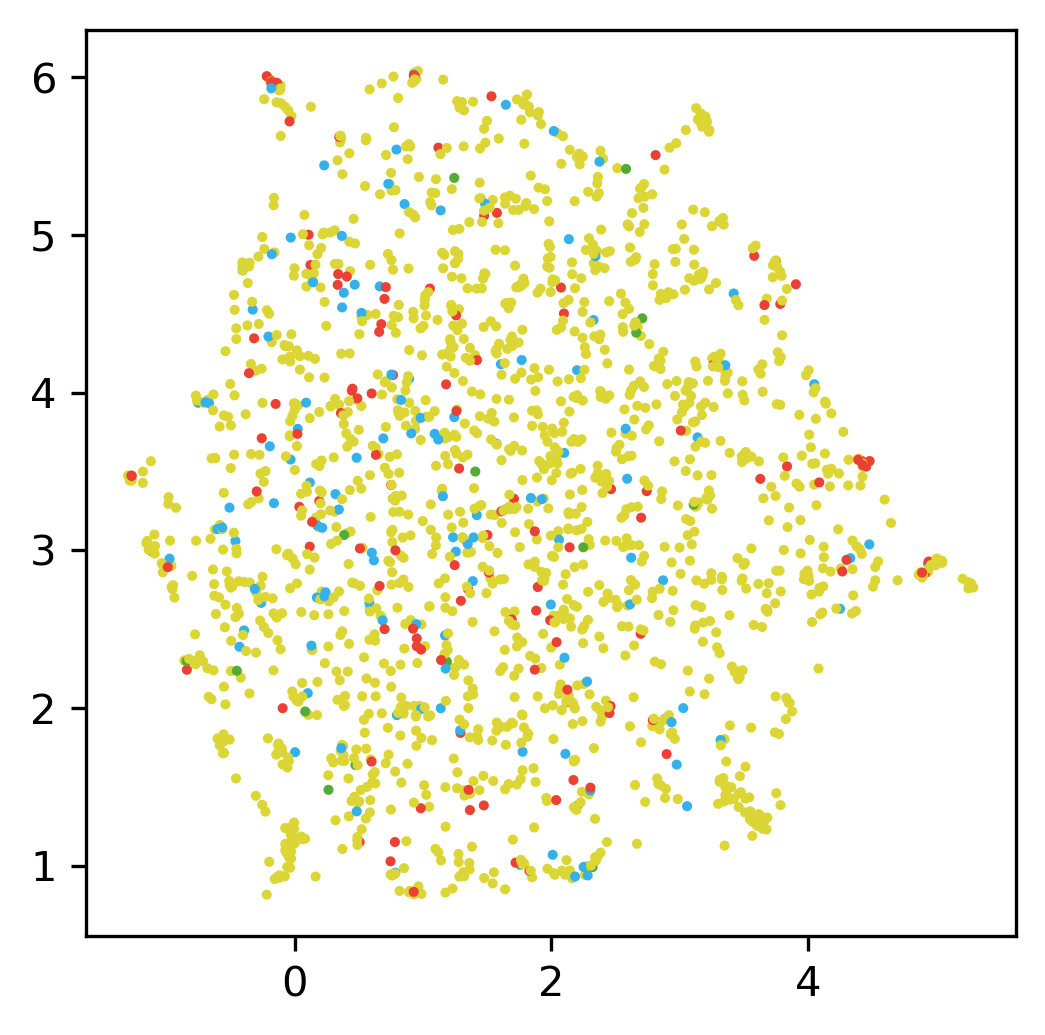

In [21]:
# create a plot of the word vectors
# reduce to two dimensions
reducer = umap.UMAP(metric='cosine', n_components=2, n_neighbors=15, min_dist=0.00, random_state=0)

# X holds the word vectors for all words in vocabulary
X = word2vec.syn1neg

# transform to two dimensions
embedding = reducer.fit_transform(X[:,:])

# plot projected word vectors
plt.figure(figsize=(4,4), dpi=300)

# scatterplot of projected word vectors
colors = {"INSULT": '#eb4034',
          "OTHER": "#dbd635",
          "ABUSE": '#34b1eb',
          "PROFANITY": "#52ab32"}

plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c = [colors.get(cat, " ") for cat in list(category_dict.values())[:]],
    s = 2
    )

In [22]:
# enable interactive plots
%matplotlib notebook

<IPython.core.display.Javascript object>


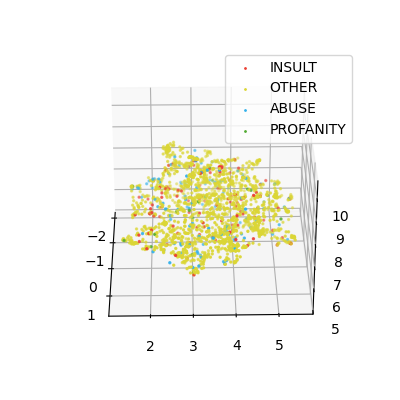

In [23]:
# maybe we should plot this with 3 dimensions 
# Project into 3D space
reducer3D = umap.UMAP(metric='cosine', n_components=3, n_neighbors=15, min_dist=0.00, random_state=0)
embedding3D = reducer3D.fit_transform(X[:,:])


# plot in 3D and create animation (rotate space)
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(4,4), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(
    embedding3D[:, 0],
    embedding3D[:, 1],
    embedding3D[:, 2],
    c = [colors.get(cat, " ") for cat in list(category_dict.values())[:]],
    s = 2
    )
for color in ['#eb4034',"#dbd635",'#34b1eb',"#52ab32"]:
    lbl = list(colors.keys())[list(colors.values()).index(color)]
    plt.scatter([],[], [], color=color, label=lbl)
plt.legend()

def rotate(angle):
    ax.view_init(azim=angle)

# rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 362,10), repeat=True)
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.arange(0, 360,1), repeat=False)

## Tweetvektoren berechnen

In [24]:
# calculate center of mass vector for list of words (used here for article as
# collection of words)
def get_com_vector(words : list) -> np.array:
    # list of words in the word2vec model
    words = [word for word in words if word in word2vec.wv.index_to_key]
    # get the vectors
    vectors = np.array([word2vec.wv.get_vector(word) for word in words])
    # return the sum of all vectors devided by the amount of words from words in the model
    vector = np.sum(vectors, axis=0)
    return vector / len(words)

# get vector for each tweet
tweet_vectors = []
for tweet in tweet_words:
    vec = get_com_vector(tweet)
    tweet_vectors.append(vec)


In [25]:
# function to preprocess and transform new tweets
def new_tweet_vector(tweet : str):
    prep_new = process_tweets(tweet)
    doc_new = nlp(prep_new)

    words_new = [
                    word.lemma_ for word in doc_new
                    if (not word.is_stop) and (len(word)>2)
                 ]

    # calculate vector for new article
    new_tweet_v = get_com_vector(words_new)

    return new_tweet_v, words_new

## Modelling

In [26]:
# create tweet vectors of test tweets
new_tweet_v = []
words_new = []
for tweet in data_test.tweets_clean:
    new_tweet_v.append(new_tweet_vector(tweet)[0])
    words_new.append(new_tweet_vector(tweet)[1])

/var/folders/gz/m10sqzrs1zv7071q82xq75fh0000gn/T/ipykernel_12737/2279988988.py:10: RuntimeWarning: invalid value encountered in double_scalars
  return vector / len(words)


In [27]:
# Remove tweets where there are no words in the word2vec model  
tweet_words_dict = remove_nan_tweets(words_new, word2vec.wv.index_to_key)   

# subset data_test and tweet_words, only tweets where at least one word is in the word2vec model
data_test = data_test.iloc[list(tweet_words_dict.keys()), :]
data_test = data_test.reset_index()
new_tweet_v = [new_tweet_v[i] for i in list(tweet_words_dict.keys())]

In [28]:
# Encode the classes
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
y_transformed = encoder.fit_transform(data_pre["granulareKlassifikation"])
encoder.classes_

array(['ABUSE', 'INSULT', 'OTHER', 'PROFANITY'], dtype=object)

In [29]:
# Train a Random Forest
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(tweet_vectors, y_transformed)
rfc_predictions = rfc.predict(new_tweet_v)
# rfc_human_readeable = encoder.inverse_transform(rfc_predictions)

In [30]:
# transform predictions to classes
encoder_dict = dict(enumerate(encoder.classes_.flatten(), 0))
rfc_predictions = [encoder_dict[x] for x in rfc_predictions]

## Evaluation

In [31]:
# calculate accuracy
acc = 0
for i in range(len(rfc_predictions)):
    if rfc_predictions[i] == data_test["granulareKlassifikation"][i]:
        acc += 1
accuracy = acc / len(rfc_predictions)        

In [32]:
print("Accuracy: " + str(accuracy))

Accuracy: 0.7695473251028807


In [33]:
# classification report
from sklearn.metrics import classification_report
print(classification_report(data_test["granulareKlassifikation"], rfc_predictions))

              precision    recall  f1-score   support

       ABUSE       1.00      0.38      0.55        85
      INSULT       0.97      0.43      0.60       167
       OTHER       0.73      1.00      0.84       451
   PROFANITY       1.00      0.31      0.47        26

    accuracy                           0.77       729
   macro avg       0.93      0.53      0.61       729
weighted avg       0.83      0.77      0.74       729



In [34]:
# value counts of predictions
[[x, rfc_predictions.count(x)] for x in ['ABUSE', 'PROFANITY','INSULT', 'OTHER']]

[['ABUSE', 32], ['PROFANITY', 8], ['INSULT', 74], ['OTHER', 615]]

In [35]:
# value counts of actual values
data_test["granulareKlassifikation"].value_counts()

OTHER        451
INSULT       167
ABUSE         85
PROFANITY     26
Name: granulareKlassifikation, dtype: int64